## Import packages

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys
import seaborn as sns

sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading,assembly_run

sys.path.append(r'D:\github\neurocode\reactivation\assemblies')
import assembly

import nelpy as nel
import nelpy.plotting as npl

import itertools
import os

import pickle
from scipy import stats
import glob
from scipy.stats import chisquare

from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import random
from tqdm import tqdm

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
functions.set_plotting_defaults()

In [4]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Run main analysis to detect cell assemblies inside and out of ripples

In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly'
assembly_run.assembly_run(df,save_path,parallel=True)

## load data from cell_assembly

In [4]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly'

sessions = glob.glob(save_path +os.sep+ '*.pkl')

UID = []
deepSuperficial = []
weights = []
membership = []
df = pd.DataFrame()
assembly_n = 0
assembly_ = []
basepath = []
assembly_path = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    for pattern in results['patterns_inside_ripples']:
        UID.append(results['UID'])
        deepSuperficial.append(results['deepSuperficial'])
        weights.append(pattern)
        thres = np.mean(pattern) + np.std(pattern)*2
        membership.append(pattern > thres)
        assembly_.append([assembly_n]*len(pattern))
        assembly_n += 1
        basepath.append([results['basepath']]*len(pattern))
        assembly_path.append([session]*len(pattern))

df['UID'] = np.hstack(UID)
df['basepath'] = np.hstack(basepath)
df['deepSuperficial'] = np.hstack(deepSuperficial)
df['weights'] = np.hstack(weights)
df['membership'] = np.hstack(membership)
df['assembly_n'] = np.hstack(assembly_)
df['assembly_path'] = np.hstack(assembly_path)

df

,UID,basepath,deepSuperficial,weights,membership,assembly_n,assembly_path
0,1,Z:\Data\AYAold\AB1\day1,Deep,-0.068668,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
1,2,Z:\Data\AYAold\AB1\day1,Superficial,0.025379,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
2,9,Z:\Data\AYAold\AB1\day1,Deep,-0.064106,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
3,10,Z:\Data\AYAold\AB1\day1,Superficial,0.052817,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
4,12,Z:\Data\AYAold\AB1\day1,Deep,-0.157216,False,0,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
...,...,...,...,...,...,...,...
51049,112,Z:\Data\ORproject\OR23\day5,Deep,-0.092685,False,964,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
51050,113,Z:\Data\ORproject\OR23\day5,Deep,-0.012515,False,964,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
51051,114,Z:\Data\ORproject\OR23\day5,Deep,0.016179,False,964,Z:\home\ryanh\projects\ripple_heterogeneity\ce...
51052,115,Z:\Data\ORproject\OR23\day5,Superficial,0.025150,False,964,Z:\home\ryanh\projects\ripple_heterogeneity\ce...


In [5]:
import add_rem_shift
df = add_rem_shift.add_rem_shift(df)

In [6]:
print('n sessions',df.basepath.nunique())
print('n assemblies',df.assembly_n.nunique())
print('')
print('n deep units',(df.deepSuperficial == 'Deep').sum())
print('n sup units',(df.deepSuperficial == 'Superficial').sum())
print('')
print('n deep rem shift units',(df.layer_rem_shift == 'deep_rem_shift').sum())
print('n sup non-rem shift units',(df.layer_rem_shift == 'sup_non_rem_shift').sum())
print('')
print('n deep members',((df.deepSuperficial == 'Deep') & df.membership).sum())
print('n sup members',((df.deepSuperficial == 'Superficial') & df.membership).sum())
print('')
print('n deep rem shift members',((df.layer_rem_shift == 'deep_rem_shift') & df.membership).sum())
print('n sup non-rem shift members',((df.layer_rem_shift == 'sup_non_rem_shift') & df.membership).sum())

n sessions 209
n assemblies 965

n deep units 33910
n sup units 17144

n deep rem shift units 10780
n sup non-rem shift units 5073

n deep members 960
n sup members 418

n deep rem shift members 290
n sup non-rem shift members 106


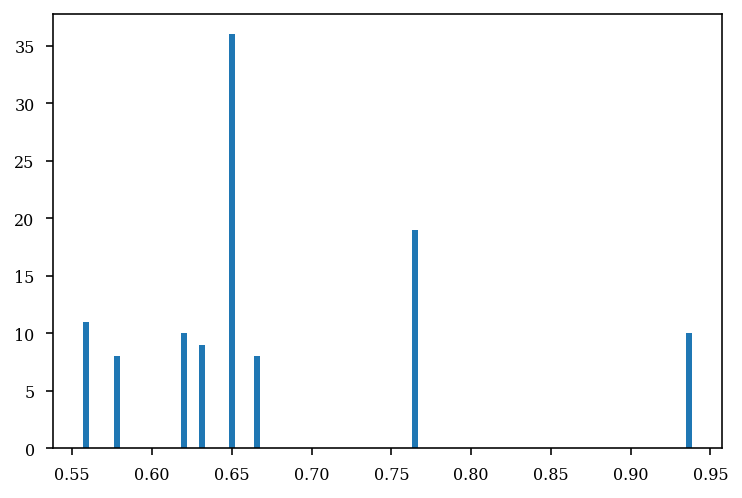

In [75]:

# def shuff_labels(df,layer,n_shuff):
#     weights = []
#     for i_shuff in range(1000):
#         labels = df['deepSuperficial'].values.copy()
#         random.shuffle(labels)

#         weights_ = df[(labels == layer)].weights
#         weights.append(weights_[weights_ > 0].median())


# rel_prop = []
# GrosmarkAD_df = df[df['basepath'].str.contains("GrosmarkAD")]
# for n_as in GrosmarkAD_df.assembly_n.unique():

#     current_df = GrosmarkAD_df[GrosmarkAD_df.assembly_n == n_as]
#     n_deep = (current_df.deepSuperficial == "Deep").sum()
#     n_sup = (current_df.deepSuperficial == "Superficial").sum()

#     deep_weights_ = current_df[(current_df.deepSuperficial == "Deep")].weights
#     deep_weights.append(deep_weights_[deep_weights_ > 0].median())

#     sup_weights_ = current_df[(current_df.deepSuperficial == "Superficial")].weights
#     sup_weights.append(sup_weights_[sup_weights_ > 0].median())

#     rel_prop.append(n_deep / (n_deep+n_sup))
#     # _,p = chisquare(np.array([n_deep,n_sup]) / (n_deep+n_sup),f_exp=[.5,.5])
#     # if p < 0.05:
#     #     print(current_df.basepath.unique(), n_as,n_deep,n_sup)
# plt.hist(rel_prop,100)
# plt.show()

## get assembly identies (deep/sup)

In [7]:


import warnings
warnings.filterwarnings("ignore")

# def shuff_labels(df,layer,n_shuff=500):
#     weights = []
#     for _ in range(n_shuff):
#         labels = df['deepSuperficial'].values.copy()
#         random.shuffle(labels)

#         weights_ = df[(labels == layer)].weights
#         weights.append(weights_[weights_ > 0].median())
#     return weights

def shuff_labels(df,layer,n_shuff=500):
    weights = []
    for _ in range(n_shuff):
        labels = df['layer_rem_shift'].values.copy()
        random.shuffle(labels)

        weights_ = df[(labels == layer)].weights
        weights.append(weights_[weights_ > 0].median())
    return weights

# def pvalue(shuff_dist,score):
#         # DOI: 10.2202/1544-6115.1585
#         return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

rel_prop_deep_sup = []
prop_deep = []
basepath = []
n_deeps = []
n_sups = []
assembly_n = []
n_deep_mem = []
n_sup_mem = []
deep_weights = []
sup_weights = []
deep_rem_weights = []
sup_rem_weights = []
deep_rem_weights_shuff = []
sup_rem_weights_shuff = []

# p_deep = []
# p_sup = []
assembly_path = []
for n_as in tqdm(df.assembly_n.unique()):
    current_df = df[df.assembly_n == n_as]
    n_deep = (current_df.deepSuperficial == "Deep").sum()
    n_sup = (current_df.deepSuperficial == "Superficial").sum()

    # if (current_df.membership.sum() > 2) & (p > 0.05) & (n_deep >= 5) & (n_sup >= 5):
    if (n_deep >= 5) & (n_sup >= 5):

        n_deep_mem.append(((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum())
        n_sup_mem.append(((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum())

        deep_weights_ = current_df[(current_df.deepSuperficial == "Deep")].weights
        deep_weights.append(deep_weights_[deep_weights_ > 0].median())

        sup_weights_ = current_df[(current_df.deepSuperficial == "Superficial")].weights
        sup_weights.append(sup_weights_[sup_weights_ > 0].median())
        
        # layer / rem-shift
        deep_weights_ = current_df[(current_df.layer_rem_shift == "deep_rem_shift")].weights
        deep_rem_weights.append(deep_weights_[deep_weights_ > 0].median())

        sup_weights_ = current_df[(current_df.layer_rem_shift == "sup_non_rem_shift")].weights
        sup_rem_weights.append(sup_weights_[sup_weights_ > 0].median())

        # layer / rem-shift shuffle labels
        deep_rem_weights_shuff.append(shuff_labels(current_df,"deep_rem_shift"))
        sup_rem_weights_shuff.append(shuff_labels(current_df,"sup_non_rem_shift"))

        # p_deep.append(pvalue(shuff_labels(current_df,"Deep"),deep_weights[-1]))
        # p_sup.append(pvalue(shuff_labels(current_df,"Superficial"),sup_weights[-1]))

        rel_prop_deep_sup.append(n_deep_mem[-1] / (current_df.membership).sum())

        prop_deep.append(((current_df.deepSuperficial == "Deep")).sum() / current_df.shape[0])
        basepath.append(current_df.basepath.unique())
        assembly_path.append(current_df.assembly_path.unique())

        assembly_n.append(n_as)
        n_deeps.append(n_deep)
        n_sups.append(n_sup)

basepath = np.hstack(basepath)
assembly_path = np.hstack(assembly_path)

prop_df = pd.DataFrame()
prop_df['basepath'] = basepath
prop_df['rel_prop_deep_sup'] = rel_prop_deep_sup
prop_df['assembly_n'] = assembly_n
prop_df['n_deep'] = n_deeps
prop_df['n_sup'] = n_sups
prop_df['n_deep_mem'] = n_deep_mem
prop_df['n_sup_mem'] = n_sup_mem
prop_df['deep_weights'] = deep_weights
prop_df['sup_weights'] = sup_weights
prop_df['deep_rem_weights'] = deep_rem_weights
prop_df['sup_rem_weights'] = sup_rem_weights
prop_df['assembly_path'] = assembly_path

# prop_df['p_deep'] = p_deep
# prop_df['p_sup'] = p_sup

labels = ['sup' if val==1 else 'deep' for val in np.argmax([prop_df.deep_weights, prop_df.sup_weights],axis=0)]
prop_df['label_by_weight'] = labels

labels = ['sup' if val==1 else 'deep' for val in np.argmax([prop_df.deep_rem_weights, prop_df.sup_rem_weights],axis=0)]
prop_df['label_by_weight_rem_shift'] = labels

# plt.hist(rel_prop_deep_sup,50)
# plt.xlabel('n deep members / n members')
# plt.ylabel('n assemblies')
# plt.axvline(.5,color='r')
# plt.show()

# plt.figure()
# plt.scatter(rel_prop_deep_sup,prop_deep,alpha=.5,color='k')
# plt.ylabel('n deep units / all units')
# plt.xlabel('n deep members / n members')
# plt.axvline(.5,color='r',zorder=-1000)
# plt.axhline(.5,color='r',zorder=-1000)
# # plt.xlim(0,1)
# plt.ylim(0,1)


100%|██████████| 965/965 [05:53<00:00,  2.73it/s]


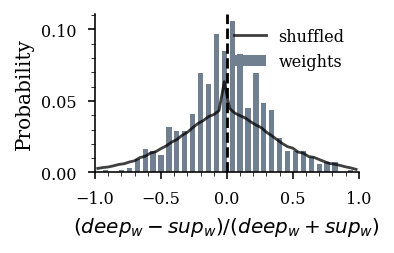

In [63]:
plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1,1)), edgecolor='k')
ratio = (prop_df.deep_weights-prop_df.sup_weights)/(prop_df.deep_weights+prop_df.sup_weights)
bin_width = .04
x = np.arange(-1,1,bin_width+bin_width/2)
binned_ratio,_ = np.histogram(ratio,bins=x)
plt.bar(x[:-1]+bin_width/2,binned_ratio/binned_ratio.sum(),width=bin_width,color="slategrey",label='weights')

plt.xlim(-1,1)
plt.axvline(0,color='k',ls='--')
plt.xlabel(r'$(deep_{w} - sup_{w}) / (deep_{w} + sup_{w})$')
plt.ylabel('Probability')

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ratio = (np.hstack(deep_rem_weights_shuff)-np.hstack(sup_rem_weights_shuff))/(np.hstack(deep_rem_weights_shuff)+np.hstack(sup_rem_weights_shuff))
# bin_width = .01
x = np.arange(-1,1+bin_width/2,bin_width)
binned_ratio,_ = np.histogram(ratio,bins=x)
plt.plot(x[:-1]+bin_width/2,binned_ratio/binned_ratio.sum(),color="k",alpha=.75,label='shuffled')

plt.legend(frameon=False,loc='best')
plt.savefig(os.path.join(fig_save_path,'deep_sup_assembly_weight.svg'),dpi=300,bbox_inches='tight')


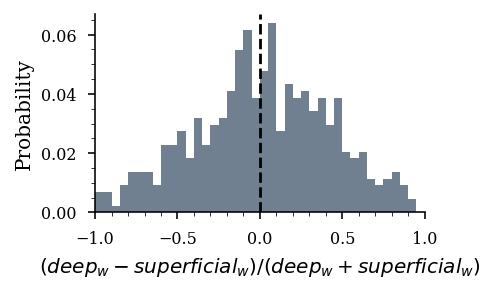

In [21]:
plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(1,1)), edgecolor='k')
ratio = (prop_df.deep_rem_weights-prop_df.sup_rem_weights)/(prop_df.deep_rem_weights+prop_df.sup_rem_weights)
bin_width = .05
x = np.arange(-1,1,bin_width)
binned_ratio,_ = np.histogram(ratio,bins=x)
plt.bar(x[:-1]+bin_width/2,binned_ratio/binned_ratio.sum(),width=bin_width,color="slategrey")

plt.xlim(-1,1)
plt.axvline(0,color='k',ls='--')
plt.xlabel(r'$(deep_{w} - superficial_{w}) / (deep_{w} + superficial_{w})$')
plt.ylabel('Probability')

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# plt.savefig(os.path.join(fig_save_path,'deep_sup_rem_assembly_weight.svg'),dpi=300,bbox_inches='tight')


In [17]:
print('n sessions',prop_df.basepath.nunique())
# print('n sessions',prop_df.basepath.unique())

print('n assemblies',prop_df.basepath.shape[0])

n_deep = []
n_sup = []
n_deep_mem = []
n_sup_mem = []

for basepath in prop_df.basepath:
    n_deep.append(prop_df[prop_df.basepath == basepath].n_deep.iloc[0])
    n_sup.append(prop_df[prop_df.basepath == basepath].n_sup.iloc[0])
    n_deep_mem.append(prop_df[prop_df.basepath == basepath].n_deep_mem.sum())
    n_sup_mem.append(prop_df[prop_df.basepath == basepath].n_sup_mem.sum())

print('n deep units ',sum(n_deep))
print('n sup units ',sum(n_sup))

print('n deep members ',sum(n_deep_mem))
print('n sup members ',sum(n_sup_mem))

n sessions 113
n assemblies 672
n deep units  26876
n sup units  14985
n deep members  11227
n sup members  5207


Text(0, 0.5, 'Assembly membership')

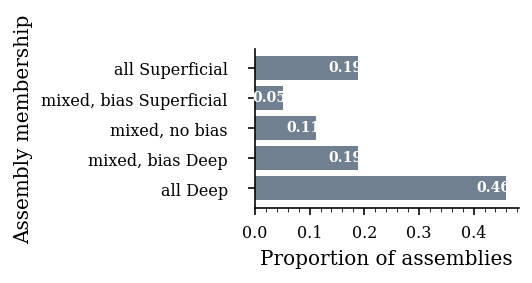

In [10]:
all_sup = prop_df.rel_prop_deep_sup == 0
all_deep = prop_df.rel_prop_deep_sup == 1
mixed_bias_sup = (prop_df.rel_prop_deep_sup > 0) & (prop_df.rel_prop_deep_sup < .5)
mixed_bias_deep = (prop_df.rel_prop_deep_sup > .5) & (prop_df.rel_prop_deep_sup < 1)
mixed_no_bias = prop_df.rel_prop_deep_sup == .5


labels = ['all Superficial','mixed, bias Superficial','mixed, no bias','mixed, bias Deep', 'all Deep']
counts = [all_sup.sum(),mixed_bias_sup.sum(),mixed_no_bias.sum(),mixed_bias_deep.sum(),all_deep.sum()]

 
fig, ax = plt.subplots(figsize=functions.set_size('thesis', fraction=.4, subplots=(1,1)), edgecolor='k')
 
# Horizontal Bar Plot
ax.barh(labels,counts / sum(counts),color='slategrey')
 
# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()-.055, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 7, fontweight ='bold',
             color ='w',zorder=100)

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel('Proportion of assemblies') 
ax.set_ylabel('Assembly membership')             

# plt.savefig(os.path.join(fig_save_path,'assembly_unit_id.svg'),dpi=300,bbox_inches='tight')

In [58]:
# np.argsort(results['deepSuperficial'])
sort_idx = np.argsort(results['deepSuperficial'])
# sort_idx
# results['deepSuperficial'] = results['deepSuperficial'].iloc[sort_idx]
patterns = results['patterns_inside_ripples']

patterns = [pat[sort_idx] for pat in patterns]
# np.array(patterns)
# results['patterns_inside_ripples'][sort_idx]

## Example figures

In [30]:
basepath = 'Z:\Data\AYAold\AB1\day1'
cell_metrics,data,ripples,fs_dat = assembly_run.load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
# behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
#                                                 data['epochs'].stopTime]).T])

filename = glob.glob(os.path.join(basepath,'*.lfp'))[0]
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

rip_ch = ripples.ripple_channel.unique()[0]
for sh in shank_to_channel:
    if np.any(shank_to_channel[sh] == rip_ch):
        shank = sh
        break

channel_idx = np.where(shank_to_channel[shank] == rip_ch)[0][0]

lfp,ts = loading.loadLFP(filename, n_channels=nChannels, channel=shank_to_channel[shank], frequency=fs, precision='int16')
lfp_obj = nel.AnalogSignalArray(data=lfp.T,fs=fs)


In [31]:
session = 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\cell_assembly_v1\\Z__Data_AYAold_AB1_day1.pkl'
with open(session, 'rb') as f:
    results = pickle.load(f)

z_mat,ts = assembly_run.get_z_t(st_unit)
assemblyAct = assembly.computeAssemblyActivity(results['patterns_inside_ripples'], z_mat)
assembly_act = nel.AnalogSignalArray(data=assemblyAct,timestamps=ts,fs=1000)

In [34]:
# st_unit.get_event_firing_order()
# rip = 9
n_deep = []
n_sup = []

for rip in ripple_epochs:
    idx = st_unit[rip].n_events > 0
    if type(idx) != type(True):
        n_deep.append(sum(cell_metrics.deepSuperficial[idx] == 'Deep'))
        n_sup.append(sum(cell_metrics.deepSuperficial[idx] == 'Superficial'))
    else:
        n_deep.append(np.nan)
        n_sup.append(np.nan)

In [35]:
# n_supn_sup == 0
np.argsort((np.array(n_deep)-np.array(n_sup)))[:20]
# print([n_deep/n_sup])

# print(n_deep[587],n_sup[587])

array([ 508,  156, 1358, 1138, 1109,  858,   69,  361,  404,  894,  341,
        912,  705, 1320,   31,  637,  781, 1414,  492, 1158], dtype=int64)

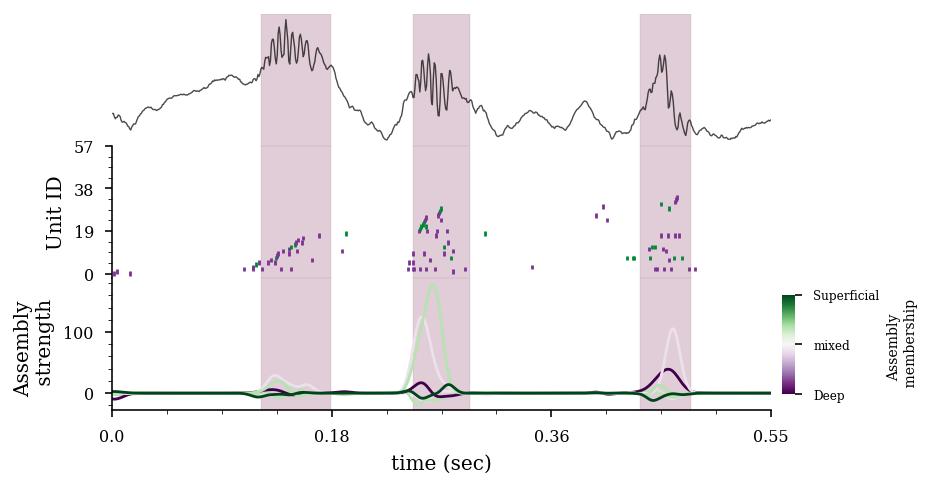

In [41]:
# from neurodsp.filt import filter_signal
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(3,1, figsize=functions.set_size('thesis', fraction=1, subplots=(1.5,1.5)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

# rip = 9
rip = 1358
rip = 71

window = .5
plotting_epoch = nel.EpochArray([np.array([ripple_epochs[rip].start-window/2,ripple_epochs[rip].stop+window/2]).T])

# Define a frequency range to filter the data
f_range = (100, 250)
# Bandpass filter the data, across the band of interest
# sig_filt = filter_signal(lfp_obj[plotting_epoch].data[channel_idx], fs, 'bandpass', f_range)
axs[0].plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data[channel_idx],
            color='k',alpha=.7,linewidth=.7,label='ripple bandpass filtered')

# sort by deepSuperficial
colors1 = np.array(['#7b3294']*cell_metrics.shape[0])
colors1[cell_metrics.deepSuperficial == "Superficial"] = '#008837'
sort_idx = np.argsort(cell_metrics['deepSuperficial'])

fr_order = np.array(st_unit[plotting_epoch].get_event_firing_order())-1
axs[1].eventplot(st_unit[plotting_epoch].data[fr_order],color=colors1[fr_order],linelengths=2)

deep_median = []
sup_median = []
for pattern in results['patterns_inside_ripples']:
    deep_median.append(np.median(pattern[(results['deepSuperficial'] == 'Deep') & (pattern > 0)]))
    sup_median.append(np.median(pattern[(results['deepSuperficial'] == 'Superficial') & (pattern > 0)]))

ratio = (np.array(sup_median) - np.array(deep_median)) / (np.array(sup_median) + np.array(deep_median))
norm = matplotlib.colors.Normalize(vmin=ratio.min(), vmax=ratio.max())
cmap = matplotlib.cm.get_cmap('PRGn')
rgba = cmap(norm(ratio))
for i,c in enumerate(rgba):
    axs[2].plot(assembly_act[plotting_epoch].abscissa_vals,assembly_act[plotting_epoch].data[i],color=c)

axins = inset_axes(axs[2],
                    width="2%",  
                    height="75%",
                    loc='right',
                    borderpad=-1.5
                   )
sm = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(vmin=-1, vmax=1))
cbar = fig.colorbar(sm, cax=axins,ticks=[-1, 0, 1])
cbar.outline.set_visible(False)
cbar.ax.set_yticklabels(['Deep', 'mixed', 'Superficial'],fontsize=6)
axins.set_ylabel('Assembly \n membership',fontsize=7)

for rip in ripple_epochs[plotting_epoch]:
    axs[0].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)
    axs[1].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)
    axs[2].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)

x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
axs[2].set_xticks(x)
axs[2].set_xticklabels(np.round(x-plotting_epoch.start,2))

axs[1].set_yticks(np.linspace(0,cell_metrics.UID.unique().shape[0],4))
axs[1].set_ylim(-2,cell_metrics.UID.unique().shape[0])
axs[1].set_ylabel('Unit ID')

axs[2].set_xlabel('time (sec)')
axs[2].set_ylabel('Assembly \n strength')

for i in range(3):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)  

axs[1].spines["bottom"].set_visible(False)

axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[2].yaxis.set_minor_locator(AutoMinorLocator())
axs[2].xaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'ripple_deep_sup_example_v2.svg'),dpi=300,bbox_inches='tight')


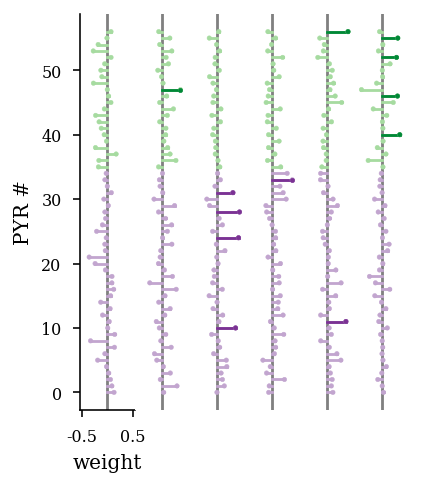

In [19]:
session = 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\cell_assembly_v1\\Z__Data_AYAold_AB1_day1.pkl'
with open(session, 'rb') as f:
    results = pickle.load(f)

# first, sort cells by sublayer
sort_idx = np.argsort(results['deepSuperficial'])
results['deepSuperficial'] = results['deepSuperficial'].iloc[sort_idx]

patterns = results['patterns_inside_ripples']
patterns = [pat[sort_idx] for pat in patterns]
patterns = np.array(patterns)

# get colors per sub group
colors = ['#c2a5cf']* results['deepSuperficial'].shape[0]
colors = np.array(colors)
colors[results['deepSuperficial'] == 'Deep'] = ['#c2a5cf']*sum(results['deepSuperficial'] == 'Deep')
colors[results['deepSuperficial'] == 'Superficial'] = ['#a6dba0']*sum(results['deepSuperficial'] == 'Superficial')

colors_sig = ['#7b3294']* results['deepSuperficial'].shape[0]
colors_sig = np.array(colors_sig)
colors_sig[results['deepSuperficial'] == 'Deep'] = ['#7b3294']*sum(results['deepSuperficial'] == 'Deep')
colors_sig[results['deepSuperficial'] == 'Superficial'] = ['#008837']*sum(results['deepSuperficial'] == 'Superficial')


fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=.5, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors,zorder=1000,s=5)

    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(assmbl[idx],np.arange(len(assmbl))[idx],c=colors_sig[idx],zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[j],zorder=-50)
        if idx[j]:
            axs[i].plot(np.sort([item,0]),[j,j],color=colors_sig[j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

    for i in range(patterns.shape[0]):
        axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)

    for i in range(patterns.shape[0]):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)  

    for i in np.arange(1,patterns.shape[0]):
        axs[i].spines["left"].set_visible(False)  
        axs[i].spines["bottom"].set_visible(False)      
        axs[i].get_yaxis().set_ticks([])
        axs[i].get_xaxis().set_ticks([])

    axs[0].set_ylabel('PYR #')
    axs[0].set_xlabel('weight')
    axs[0].set_xticks([-.5,.5])
    axs[0].set_xticklabels([-.5,.5])

plt.savefig(os.path.join(fig_save_path,'assembly_weight_example.svg'),dpi=300,bbox_inches='tight')


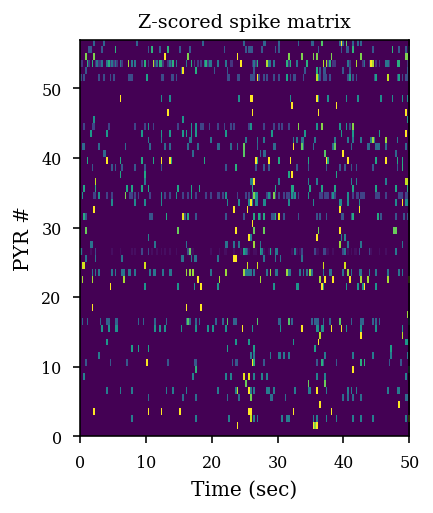

In [30]:
plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')
sort_idx = np.argsort(results['deepSuperficial'])

plt.imshow(results['zactmat_inside_ripples'][sort_idx,2500:2700],aspect='auto',interpolation='nearest',origin='lower',extent=[0,200*.25,0,patterns.shape[1]],vmax=5,vmin=0)
plt.ylabel('PYR #')
plt.xlabel('Time (sec)')
plt.title('Z-scored spike matrix')

# axs = plt.gca()
# for i, label in enumerate(('A')):
#     axs.text(-0.15, 1.2, label, transform=axs.transAxes,
#         fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(os.path.join(fig_save_path,'assembly_zactmat_example.svg'),dpi=300,bbox_inches='tight')


## Pairwise corr of members and non members + deep/sup

In [28]:
# test_df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs\Z__Data_AYAold_AB1_day1.csv')

# plt.plot(test_df.assembly_id)

In [8]:
import importlib
import assembly_corrs_w_rem_shift
importlib.reload(assembly_corrs_w_rem_shift)

# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs'
# assembly_corrs.assembly_corr_run(df,save_path,parallel=False)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_rem_shift'
assembly_corrs_w_rem_shift.assembly_corr_run(df,save_path,parallel=True)

### load in saved data

In [9]:
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs'
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_rem_shift'

corr_df = pd.DataFrame()
sessions = glob.glob(save_path +os.sep+ '*.csv')
for session in sessions:
    temp_df = pd.read_csv(session)
    corr_df = corr_df.append(temp_df,ignore_index=True)
corr_df

,Unnamed: 0,rho,label,assembly_id,basepath
0,0,0.220312,member,1.0,Z:\Data\AYAold\AB1\day1
1,1,0.147429,member,2.0,Z:\Data\AYAold\AB1\day1
2,2,0.159997,member,2.0,Z:\Data\AYAold\AB1\day1
3,3,0.100080,member,2.0,Z:\Data\AYAold\AB1\day1
4,4,0.235745,member,4.0,Z:\Data\AYAold\AB1\day1
...,...,...,...,...,...
2864503,22609,-0.013259,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5
2864504,22610,-0.021230,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5
2864505,22611,0.004508,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5
2864506,22612,-0.022553,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5


In [163]:
# corr_df['r2'] = corr_df.rho**2

In [177]:
# crosscorrs = assembly_corrs.pairwise_cross_corr(st_unit.data, binsize = 0.001, nbins = 100)
# st_unit.data

In [178]:
# plt.plot(crosscorrs)
# plt.show()

Text(0, 0.5, 'Proportion of cells')

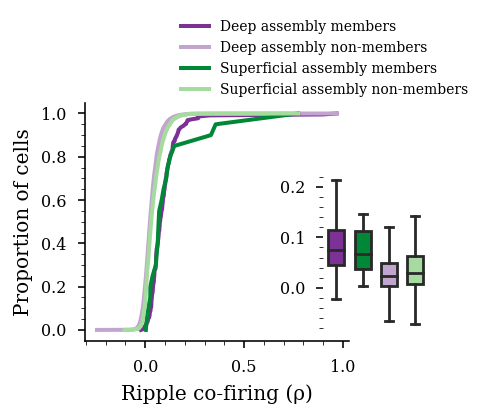

In [10]:
import custom_plots
importlib.reload(custom_plots)

group_colors = {"member_deep": '#7b3294',
            'member_sup': '#008837',
            "non_member_deep": '#c2a5cf',
            'non_member_sup': '#a6dba0'}

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')

axs = plt.gca()

idx = (
    (corr_df.label == 'member_deep') |
    (corr_df.label == 'non_member_deep') |
    (corr_df.label == 'member_sup') |
    (corr_df.label == 'non_member_sup')
)

custom_plots.plot_ecdf('rho',corr_df[idx],'label','member_deep',axs,group_colors,linewidth=2,label="Deep assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','non_member_deep',axs,group_colors,linewidth=2,label="Deep assembly non-members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','member_sup',axs,group_colors,linewidth=2,label="Superficial assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','non_member_sup',axs,group_colors,linewidth=2,label="Superficial assembly non-members")

ax = custom_plots.plot_box(corr_df[idx],'label','rho',axs,fig,group_colors,x_offset=.7,showfliers=False)

axs.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.4),fontsize='x-small',frameon=False)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel('Ripple co-firing (ρ)')
axs.set_ylabel('Proportion of cells')

# plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation.svg'),dpi=300,bbox_inches='tight')

In [11]:
corr_df[idx].label.unique()

array(['non_member_deep', 'non_member_sup', 'member_sup', 'member_deep'],
      dtype=object)

In [12]:
val = list(group_colors.keys())
val

['member_deep', 'member_sup', 'non_member_deep', 'non_member_sup']

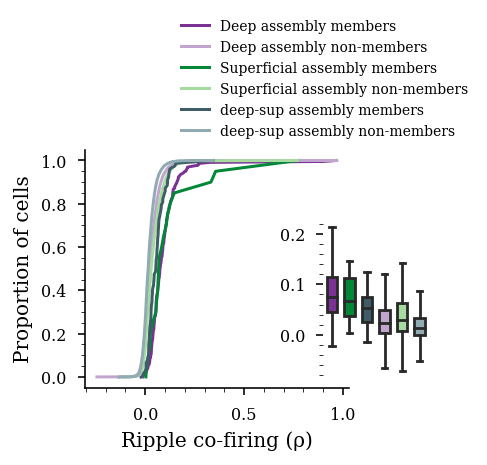

In [19]:
import custom_plots
importlib.reload(custom_plots)

group_colors = {"member_deep": '#7b3294',
            'member_sup': '#008837',
            "member_deep_sup": '#3e5d66',
            "non_member_deep": '#c2a5cf',
            'non_member_sup': '#a6dba0',
            "non_member_deep_sup": '#91abb3'}

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')

axs = plt.gca()

idx = (
    (corr_df.label == 'member_deep') |
    (corr_df.label == 'non_member_deep') |
    (corr_df.label == 'member_sup') |
    (corr_df.label == 'non_member_sup') |
    (corr_df.label == 'member_deep_sup') |
    (corr_df.label == 'non_member_deep_sup')
)

custom_plots.plot_ecdf('rho',corr_df[idx],'label','member_deep',axs,group_colors,linewidth=1.5,label="Deep assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','non_member_deep',axs,group_colors,linewidth=1.5,label="Deep assembly non-members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','member_sup',axs,group_colors,linewidth=1.5,label="Superficial assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','non_member_sup',axs,group_colors,linewidth=1.5,label="Superficial assembly non-members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','member_deep_sup',axs,group_colors,linewidth=1.5,label="deep-sup assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','non_member_deep_sup',axs,group_colors,linewidth=1.5,label="deep-sup assembly non-members")

ax = custom_plots.plot_box(corr_df[idx],'label','rho',axs,fig,group_colors,x_offset=.7,showfliers=False)

axs.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.6),fontsize='x-small',frameon=False)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel('Ripple co-firing (ρ)')
axs.set_ylabel('Proportion of cells')

plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation.svg'),dpi=300,bbox_inches='tight')

## add factors

In [15]:
# for i,basepath in enumerate(corr_df.basepath):
idx = (
    (corr_df.label == 'non_member_deep') |
    (corr_df.label == 'non_member_sup') |
    (corr_df.label == 'non_member_deep_sup')
)
corr_df['membership'] = 'member'
corr_df.loc[idx,'membership']  ='non_member'
corr_df

,Unnamed: 0,rho,label,assembly_id,basepath,membership
0,0,0.220312,member,1.0,Z:\Data\AYAold\AB1\day1,member
1,1,0.147429,member,2.0,Z:\Data\AYAold\AB1\day1,member
2,2,0.159997,member,2.0,Z:\Data\AYAold\AB1\day1,member
3,3,0.100080,member,2.0,Z:\Data\AYAold\AB1\day1,member
4,4,0.235745,member,4.0,Z:\Data\AYAold\AB1\day1,member
...,...,...,...,...,...,...
2864503,22609,-0.013259,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member
2864504,22610,-0.021230,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member
2864505,22611,0.004508,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member
2864506,22612,-0.022553,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member


In [16]:
# importlib.reload(loading)
corr_df['name'] = 'unknown'
for basepath in corr_df.basepath.unique():
    corr_df.loc[corr_df.basepath == basepath,'name'] = loading.get_animal_id(basepath)
corr_df

,Unnamed: 0,rho,label,assembly_id,basepath,membership,name
0,0,0.220312,member,1.0,Z:\Data\AYAold\AB1\day1,member,AB1
1,1,0.147429,member,2.0,Z:\Data\AYAold\AB1\day1,member,AB1
2,2,0.159997,member,2.0,Z:\Data\AYAold\AB1\day1,member,AB1
3,3,0.100080,member,2.0,Z:\Data\AYAold\AB1\day1,member,AB1
4,4,0.235745,member,4.0,Z:\Data\AYAold\AB1\day1,member,AB1
...,...,...,...,...,...,...,...
2864503,22609,-0.013259,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member,OR23
2864504,22610,-0.021230,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member,OR23
2864505,22611,0.004508,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member,OR23
2864506,22612,-0.022553,non_member_deep_sup,964.0,Z:\Data\ORproject\OR23\day5,non_member,OR23


In [18]:
idx = (
    (corr_df.label == 'member_deep') |
    (corr_df.label == 'non_member_deep') |
    (corr_df.label == 'member_sup') |
    (corr_df.label == 'non_member_sup') |
    (corr_df.label == 'member_deep_sup') |
    (corr_df.label == 'non_member_deep_sup')
)
bad_idx = np.isnan(corr_df[idx].rho) | np.isinf(corr_df[idx].rho)

data = corr_df[idx & ~bad_idx]

data.to_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_rem_shift\results\df.csv')

In [22]:
# corr_df.label.unique()
corr_df['label_2'] = 'unknown'
idx = (corr_df.label == 'member_deep') | (corr_df.label == 'member_sup')
corr_df.loc[idx,'label_2'] = 'member_same_layer'

idx = (corr_df.label == 'member_deep_sup')
corr_df.loc[idx,'label_2'] = 'member_cross_layer'

idx = (corr_df.label == 'non_member_deep') | (corr_df.label == 'non_member_sup') | (corr_df.label == 'non_member_deep_sup') 
corr_df.loc[idx,'label_2'] = 'non_member'

In [24]:
corr_df.label_2.unique()

array(['unknown', 'non_member', 'member_same_layer', 'member_cross_layer'],
      dtype=object)

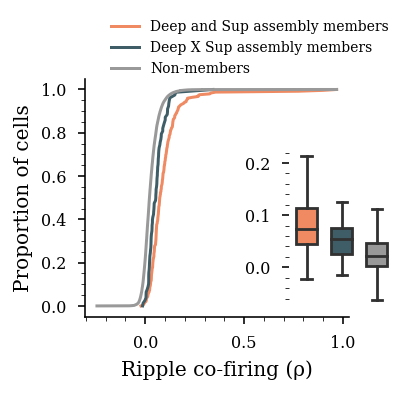

In [34]:
import custom_plots
importlib.reload(custom_plots)

# group_colors = {"member_deep": '#7b3294',
#             'member_sup': '#008837',
#             "member_deep_sup": '#3e5d66',
#             "non_member_deep": '#c2a5cf',
#             'non_member_sup': '#a6dba0',
#             "non_member_deep_sup": '#91abb3'}

group_colors = {"member_same_layer": '#ef8a62',
            'member_cross_layer': '#3e5d66',
            "non_member": '#999999'}


fig = plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')

axs = plt.gca()

idx = (
    (corr_df.label == 'member_deep') |
    (corr_df.label == 'non_member_deep') |
    (corr_df.label == 'member_sup') |
    (corr_df.label == 'non_member_sup') |
    (corr_df.label == 'member_deep_sup') |
    (corr_df.label == 'non_member_deep_sup')
)

custom_plots.plot_ecdf('rho',corr_df[idx],'label_2','member_same_layer',axs,group_colors,linewidth=1.5,label="Deep and Sup assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label_2','member_cross_layer',axs,group_colors,linewidth=1.5,label="Deep X Sup assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label_2','non_member',axs,group_colors,linewidth=1.5,label="Non-members")


ax = custom_plots.plot_box(corr_df[idx],'label_2','rho',axs,fig,group_colors,x_offset=.6,showfliers=False)

axs.legend(loc='best', bbox_to_anchor=(.7, -.3, 0.5, 1.6),fontsize='x-small',frameon=False)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel('Ripple co-firing (ρ)')
axs.set_ylabel('Proportion of cells')

plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation.svg'),dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Proportion of cells')

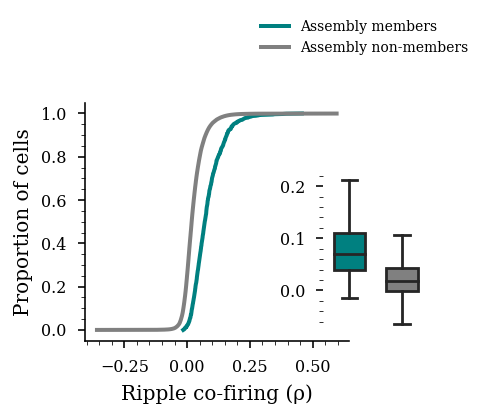

In [29]:
import custom_plots
importlib.reload(custom_plots)

group_colors = {"member_deep_sup": 'teal',
            "non_member_deep_sup": 'grey'}

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')

axs = plt.gca()

idx = (
    (corr_df.label == 'member_deep_sup') |
    (corr_df.label == 'non_member_deep_sup')
)

custom_plots.plot_ecdf('rho',corr_df[idx],'label','member_deep_sup',axs,group_colors,linewidth=2,label="Assembly members")
custom_plots.plot_ecdf('rho',corr_df[idx],'label','non_member_deep_sup',axs,group_colors,linewidth=2,label="Assembly non-members")

ax = custom_plots.plot_box(corr_df[idx],'label','rho',axs,fig,group_colors,x_offset=.7,showfliers=False)

axs.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 1.4),fontsize='x-small',frameon=False)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_xlabel('Ripple co-firing (ρ)')
axs.set_ylabel('Proportion of cells')

# plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation.svg'),dpi=300,bbox_inches='tight')

## Make pre/task/post assembly activation strength for GrosmarkAD sessions

In [13]:
import importlib
import assembly_activation
importlib.reload(assembly_activation)
importlib.reload(loading)

save_path_assembly = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly'
sessions = glob.glob(save_path_assembly +os.sep+ '*.pkl')
sessions = [string for string in sessions if 'GrosmarkAD' in string]

basepath = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    basepath.append(results['basepath'])

temp_df = pd.DataFrame()
temp_df['basepath'] = basepath    

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_activation'

assembly_activation.assembly_run_activation(temp_df,save_path,save_path_assembly,parallel=False)

Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013
Z:\Data\GrosmarkAD\Buddy\Buddy_06272013
Z:\Data\GrosmarkAD\Cicero\Cicero_09012014
Z:\Data\GrosmarkAD\Cicero\Cicero_09102014
Z:\Data\GrosmarkAD\Cicero\Cicero_09172014
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013


## discover assemblies on each epoch seperatly

In [5]:
import importlib
import assembly_individual_epochs
importlib.reload(assembly_individual_epochs)

df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df[df.basepath.str.contains('GrosmarkAD')]

# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_5ms'
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_10ms'
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_40ms'

assembly_individual_epochs.assembly_run(df,save_path,parallel=True)

### n assemblies over epochs

In [187]:
def load_assem_epoch_data(save_path):

    sessions = glob.glob(save_path +os.sep+ '*.pkl')

    assem_epoch_df = pd.DataFrame()

    for session in sessions:
        assem_epoch_df_temp = pd.DataFrame()
        prob_sig_member = []
        n_members = []
        n_assemblies = []
        n_cells = []
        epoch = []
        with open(session, 'rb') as f:
            results = pickle.load(f)

            for i,pattern_ep in enumerate(results['patterns']):
                patterns_keep,is_member_keep,keep_assembly,is_member = functions.find_sig_assemblies(pattern_ep)
                prob_sig_member.append(np.mean(is_member_keep))
                n_members.append(is_member_keep.sum())
                n_assemblies.append(patterns_keep.shape[0])
                n_cells.append(patterns_keep.shape[1])
                epoch.append(str(i))
                
            assem_epoch_df_temp['prob_sig_member'] = prob_sig_member
            assem_epoch_df_temp['n_members'] = n_members
            assem_epoch_df_temp['n_assemblies'] = n_assemblies
            assem_epoch_df_temp['n_cells'] = n_cells
            assem_epoch_df_temp['epoch'] = epoch
            assem_epoch_df_temp['basepath'] = results['basepath']
        
        assem_epoch_df = assem_epoch_df.append(assem_epoch_df_temp,ignore_index=True)

    return assem_epoch_df

assem_epoch_df = pd.DataFrame()

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_5ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '5ms'
assem_epoch_df = assem_epoch_df.append(assem_epoch_df_temp,ignore_index=True)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_10ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '10ms'
assem_epoch_df = assem_epoch_df.append(assem_epoch_df_temp,ignore_index=True)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_20ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '20ms'
assem_epoch_df = assem_epoch_df.append(assem_epoch_df_temp,ignore_index=True)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_40ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '40ms'
assem_epoch_df = assem_epoch_df.append(assem_epoch_df_temp,ignore_index=True)

In [188]:
assem_epoch_df['normalized_nassemb'] = assem_epoch_df.n_assemblies / assem_epoch_df.n_cells

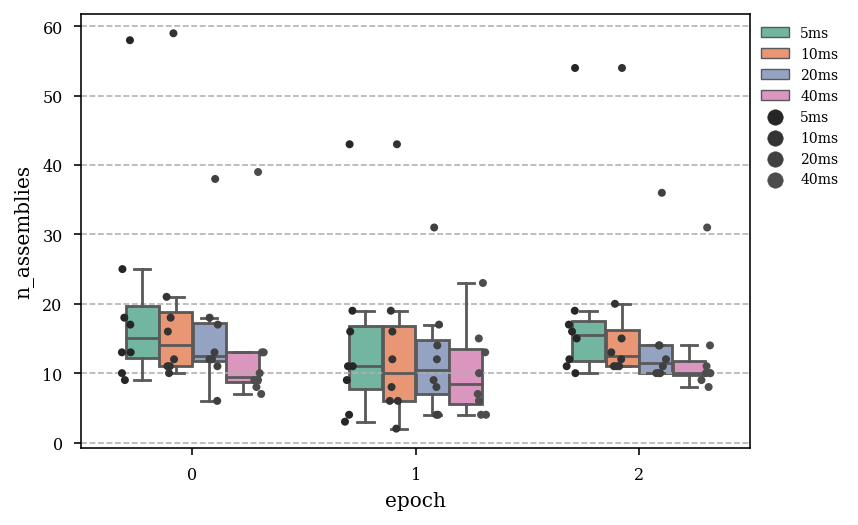

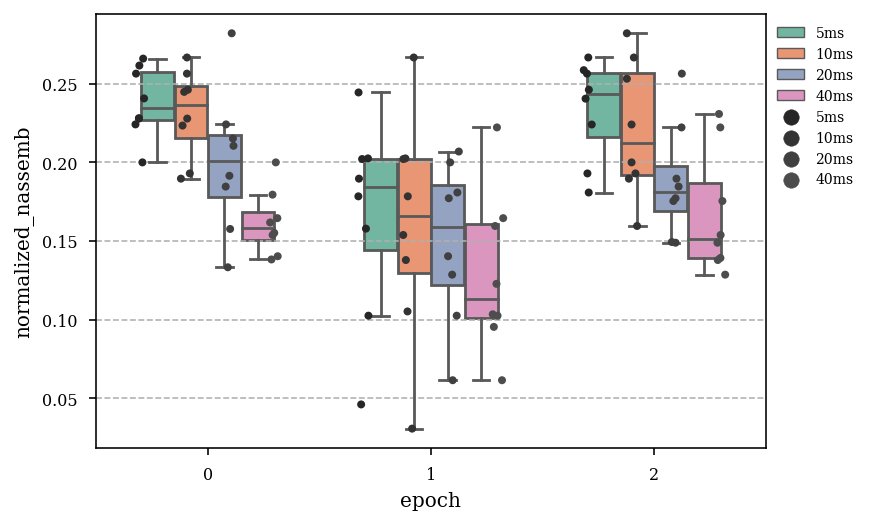

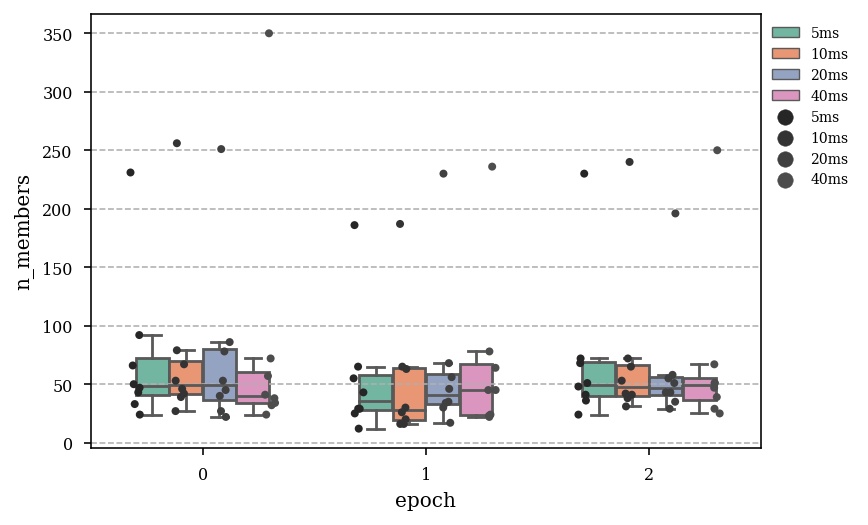

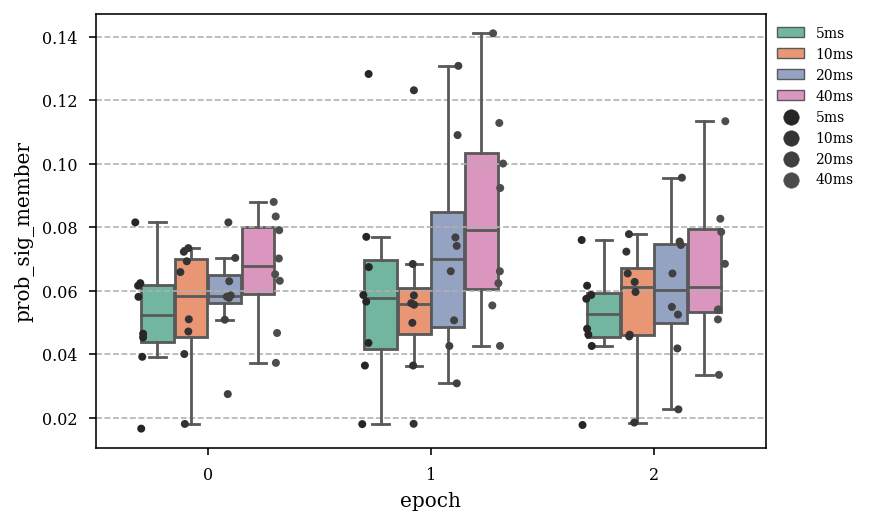

In [190]:
plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="n_assemblies", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="n_assemblies",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)


plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="normalized_nassemb", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="normalized_nassemb",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)

plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="n_members", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="n_members",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)

plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="prob_sig_member", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="prob_sig_member",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)

## 

## plot: assembly activation strength by overall participation prob. over ripples 

See if, during the novel environment exploration, the first assemblies that appear are the ones formed by high-participation cells as well

of sig members, find mean/median/range/std participation prob per assembly

for assembly strength over time, locate any peak $R >= 5$.

In [452]:
with open(sessions[0], 'rb') as f:
    results = pickle.load(f)

Text(0.5, 0, 'assemblies')

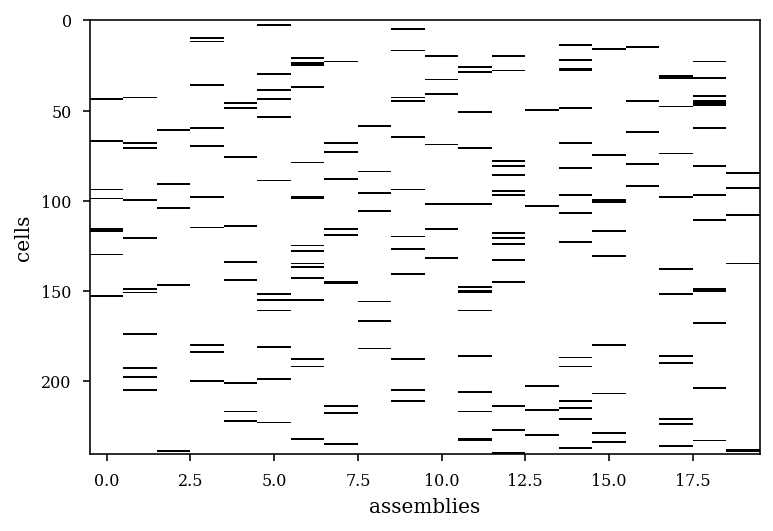

In [459]:
patterns_keep,is_member_keep,keep_idx,is_member = functions.find_sig_assemblies(results['patterns_inside_ripples'])

plt.imshow(is_member_keep.T,cmap='bone_r',aspect='auto',interpolation='nearest')
plt.ylabel('cells')
plt.xlabel('assemblies')

### fetch ripple stability data with participation per epoch/state

In [130]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

# load data from savepath
df = load_in_everything(r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability')
df = df[df.basepath.str.contains('GrosmarkAD')]


In [131]:
import importlib
import functions
importlib.reload(functions)

def get_partic_assembl_strength(results,df):

    patterns = results['patterns_inside_ripples']
    patterns_keep,is_member_keep,keep_idx,is_member = functions.find_sig_assemblies(patterns)

    participation_prob_pre_nrem = []
    participation_prob_task_wake = []
    participation_prob_post_nrem = []
    assembl_strength = []
    assembl_strength_pre = []
    assembl_strength_task = []
    assembl_strength_post = []

    for epoch_assembly_act in results['assembly_act_inside_ripples']:
        curr_assembl = epoch_assembly_act.data[keep_idx,:]

        curr_assembl[curr_assembl < 5] = np.nan
        assembl_strength.append(np.nanmedian(curr_assembl,axis=1))

    basepath_idx = df.basepath == results['basepath']
    for i,assembly_ in enumerate(is_member_keep):
        participation_prob_pre_nrem.append(df[basepath_idx & (df.epoch_n == 0)].participation_prob_nrem[assembly_].values)
        participation_prob_task_wake.append(df[basepath_idx & (df.epoch_n == 1)].participation_prob_wake[assembly_].values)
        participation_prob_post_nrem.append(df[basepath_idx & (df.epoch_n == 2)].participation_prob_nrem[assembly_].values)

        assembl_strength_pre.append([assembl_strength[0][i]]*len(participation_prob_pre_nrem[-1]))
        assembl_strength_task.append([assembl_strength[1][i]]*len(participation_prob_task_wake[-1]))
        assembl_strength_post.append([assembl_strength[2][i]]*len(participation_prob_post_nrem[-1]))

    par_assem_df = pd.DataFrame()
    par_assem_df['participation'] = np.concatenate([np.hstack(participation_prob_pre_nrem),
                                                    np.hstack(participation_prob_task_wake),
                                                    np.hstack(participation_prob_post_nrem)])

    par_assem_df['assembl_strength'] = np.concatenate([np.hstack(assembl_strength_pre),
                                                        np.hstack(assembl_strength_task),
                                                        np.hstack(assembl_strength_post)])

    par_assem_df['epoch'] = np.concatenate([['pre']*len(np.hstack(participation_prob_pre_nrem)),
                                            ['task']*len(np.hstack(participation_prob_task_wake)),
                                            ['post']*len(np.hstack(participation_prob_post_nrem))])

    par_assem_df['basepath'] = results['basepath']
    return par_assem_df

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_activation'

sessions = glob.glob(save_path +os.sep+ '*.pkl')

par_assem_df = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    temp_df = get_partic_assembl_strength(results,df)
    par_assem_df = par_assem_df.append(temp_df,ignore_index=True)

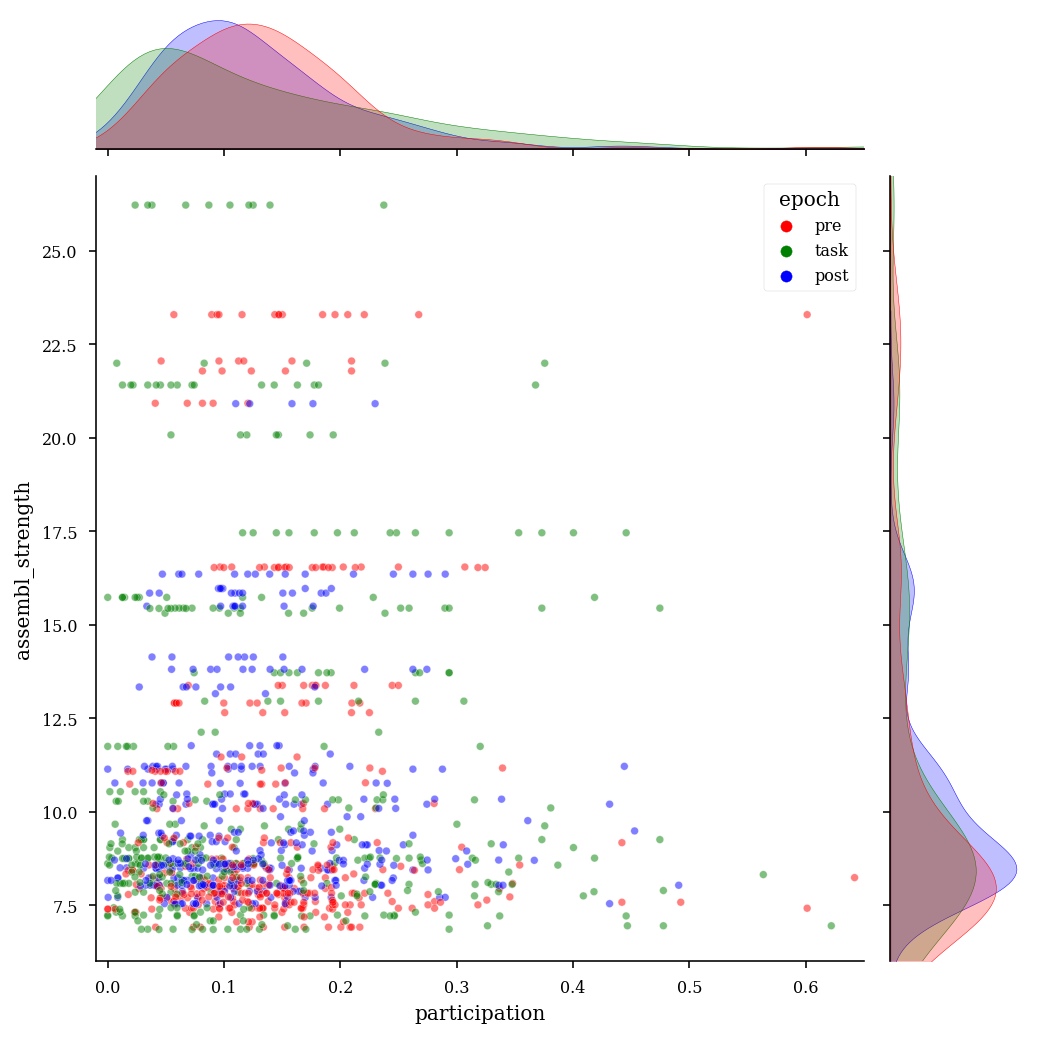

In [132]:
w,h = functions.set_size('thesis', fraction=2, subplots=(1,1))
group_colors = {"pre": 'r',
                'task': 'g',
                'post': 'b'} 
sns.set_palette(sns.color_palette(group_colors.values()))
g = sns.jointplot(
    data=par_assem_df,
    x="participation", y="assembl_strength", hue="epoch",
    height=h,s=15,alpha=.5,xlim=(-0.01,0.65),ylim=(6,27)
)
# g.set_axis_labels(xlabel='Avg. firing rate \n (task-pre)/(task+pre)', ylabel='Particip. prob. \n (post-pre)/(post+pre)')

In [133]:
import warnings
warnings.filterwarnings("ignore")

def make_df(results):
    state_dict = loading.load_SleepState_states(results['basepath'])
    nrem_epochs = nel.EpochArray(state_dict['NREMstate'])
    wake_epochs = nel.EpochArray(state_dict['WAKEstate'])
 
    assembl_strength_all = []
    assembl_frac_all = []

    patterns = results['patterns_inside_ripples']
    patterns_keep,is_member_keep,keep_idx,is_member = functions.find_sig_assemblies(patterns)

    for i,ep in enumerate(results['assembly_act_inside_ripples']):
        if (i == 0 )| (i == 2):
            ep = ep[nrem_epochs] 
        elif i == 1:
            ep = ep[wake_epochs] 

        assembl_strength = []
        assembl_frac = []
        for ripple in ep:
            curr_assembl = ripple.data[keep_idx,:]
            # Assembly strength during SPW-R periods
            assembl_strength.append(np.nanmedian(curr_assembl.max(axis=1)[curr_assembl.max(axis=1) > 5]))
            # fraction of active assemblies active during SPW-R 
            assembl_frac.append(sum(curr_assembl.max(axis=1) > 5) / curr_assembl.shape[0])

        assembl_strength_all.append(assembl_strength)
        assembl_frac_all.append(assembl_frac)

    assemb_df = pd.DataFrame()

    for i in range(3):
        df1 = pd.DataFrame()
        df1['assembl_strength'] = assembl_strength_all[i]
        df1['assembl_frac'] = assembl_frac_all[i]
        df1['epoch'] = str(i)

        assemb_df = assemb_df.append(df1,ignore_index=True)
    return assemb_df

sessions = glob.glob(save_path +os.sep+ '*.pkl')
assemb_df = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    temp_df = make_df(results)
    temp_df['basepath'] = results['basepath']
    assemb_df = assemb_df.append(temp_df,ignore_index=True)

assemb_df['assembl_strength_log'] = np.log10(assemb_df.assembl_strength)


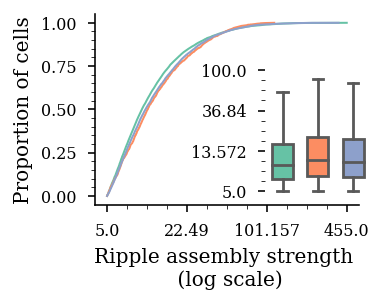

In [172]:
import custom_plots

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.2, 1)))

# group_colors = {'0':'#fff7ec','1':'#fc8d59','2':'#7f0000'}
# group_colors = {'0':'#a6bddb','1':'#3690c0','2':'#045a8d'}
cmap = matplotlib.cm.get_cmap('Set2',3)
cmap = matplotlib.cm.get_cmap('Set2',8)

group_colors = {'0':cmap(0),'1':cmap(1),'2':cmap(2)}

# group_colors = {'0':'#a6bddb','1':'#02818a','2':'#014636'}

ax = plt.gca()
idx = ~np.isnan(assemb_df.assembl_strength)
custom_plots.plot_ecdf('assembl_strength_log',assemb_df[idx],'epoch','0',ax,group_colors)
custom_plots.plot_ecdf('assembl_strength_log',assemb_df[idx],'epoch','1',ax,group_colors)
custom_plots.plot_ecdf('assembl_strength_log',assemb_df[idx],'epoch','2',ax,group_colors)

ax2 = custom_plots.plot_box(assemb_df,'epoch','assembl_strength_log',ax,fig,group_colors,x_offset=.5,showfliers=False)

custom_plots.restore_natural_scale(ax,np.log10(5),np.log10(455),n_steps=4,x_axis=True,y_axis=False)
custom_plots.restore_natural_scale(ax2,np.log10(5),np.log10(100),n_steps=4,x_axis=False,y_axis=True)

ax.set_ylabel('Proportion of cells')
ax.set_xlabel('Ripple assembly strength \n (log scale)')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'activation_strength_pre_task_post.svg'),dpi=300,bbox_inches='tight')

# Testing below

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def make_df(results):
    state_dict = loading.load_SleepState_states(results['basepath'])
    nrem_epochs = nel.EpochArray(state_dict['NREMstate'])
    wake_epochs = nel.EpochArray(state_dict['WAKEstate'])
 
    assembl_strength_all = []
    assembl_frac_all = []

    patterns = results['patterns_inside_ripples']
    patterns_keep,is_member_keep,keep_idx,is_member = functions.find_sig_assemblies(patterns)

    for i,ep in enumerate(results['assembly_act_inside_ripples']):
        if (i == 0 )| (i == 2):
            ep = ep[nrem_epochs] 
        elif i == 1:
            ep = ep[wake_epochs] 

        assembl_strength = []
        assembl_frac = []
        for ripple in ep:
            curr_assembl = ripple.data[keep_idx,:]
            # Assembly strength during SPW-R periods
            assembl_strength.append(np.nanmedian(curr_assembl.max(axis=1)[curr_assembl.max(axis=1) > 5]))
            # fraction of active assemblies active during SPW-R 
            assembl_frac.append(sum(curr_assembl.max(axis=1) > 5) / curr_assembl.shape[0])

        assembl_strength_all.append(assembl_strength)
        assembl_frac_all.append(assembl_frac)

    assemb_df = pd.DataFrame()

    for i in range(3):
        df1 = pd.DataFrame()
        df1['assembl_strength'] = assembl_strength_all[i]
        df1['assembl_frac'] = assembl_frac_all[i]
        df1['epoch'] = i

        assemb_df = assemb_df.append(df1,ignore_index=True)
    return assemb_df

sessions = glob.glob(save_path +os.sep+ '*.pkl')
assemb_df = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    temp_df = make_df(results)
    temp_df['basepath'] = results['basepath']
    assemb_df = assemb_df.append(temp_df,ignore_index=True)

In [15]:
# prob_deep = []
# prob_sup = []
rel_prop_deep_sup = []
for n_as in df.assembly_n.unique():
    current_df = df[df.assembly_n == n_as]
    if (current_df.membership.sum() > 1) & (current_df.deepSuperficial.nunique() > 1):

        n_deep = ((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum()
        n_sup = ((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum()
        rel_prop_deep_sup.append((n_sup - n_deep) / (n_deep + n_sup))
   
        # prob_deep.append(((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum() / (current_df.membership).sum())
        # prob_sup.append(((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum() / (current_df.membership).sum())


In [32]:
shuff_out = []
for i_shuff in range(1000):
    labels = df['deepSuperficial'].values.copy()
    random.shuffle(labels)
    for n_as in df.assembly_n.unique():
        current_labels = labels[df.assembly_n == n_as]
        shuff_out.append((current_labels[(df[df.assembly_n == n_as].membership == True)] == "Deep").sum() / (current_labels == "Deep").sum())


In [66]:
((df[df.assembly_n == 2].deepSuperficial == 'Deep') & (df[df.assembly_n == 2].membership)).sum()

print((df.deepSuperficial == "Deep").sum())
print((df.deepSuperficial == "Superficial").sum())


print(((df.deepSuperficial == "Deep") & (df.membership)).sum())
print(((df.deepSuperficial == "Superficial") & (df.membership)).sum())


34323
17427
857
436


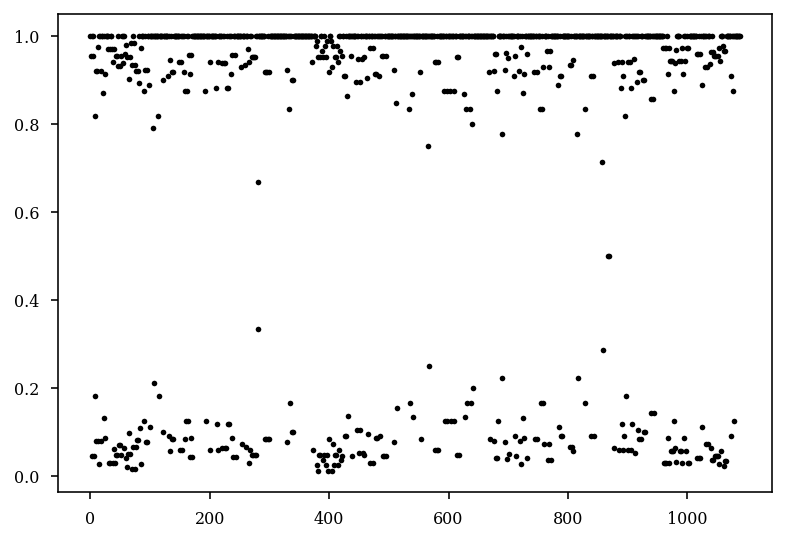

In [101]:
# from scipy.stats.contingency import margins
# print(df.groupby('deepSuperficial').membership.value_counts())
# print(df.groupby('deepSuperficial').membership.count())

# print(df.groupby('deepSuperficial').membership.value_counts() / df.groupby('deepSuperficial').membership.count())

# df.groupby(['deepSuperficial','assembly_n']).membership.count()
group_by_df = df.groupby(['deepSuperficial','assembly_n']).membership.value_counts() / df.groupby(['deepSuperficial','assembly_n']).membership.count()
# group_by_df['membership']
# df.groupby(['deepSuperficial','assembly_n']).membership.apply(lambda g: g.value_counts()/len(g))
# plt.plot(group_by_df['Deep'].values,'.k')
plt.plot(group_by_df['Superficial'].values,'.k')


<AxesSubplot:xlabel='assembly_n', ylabel='weights'>

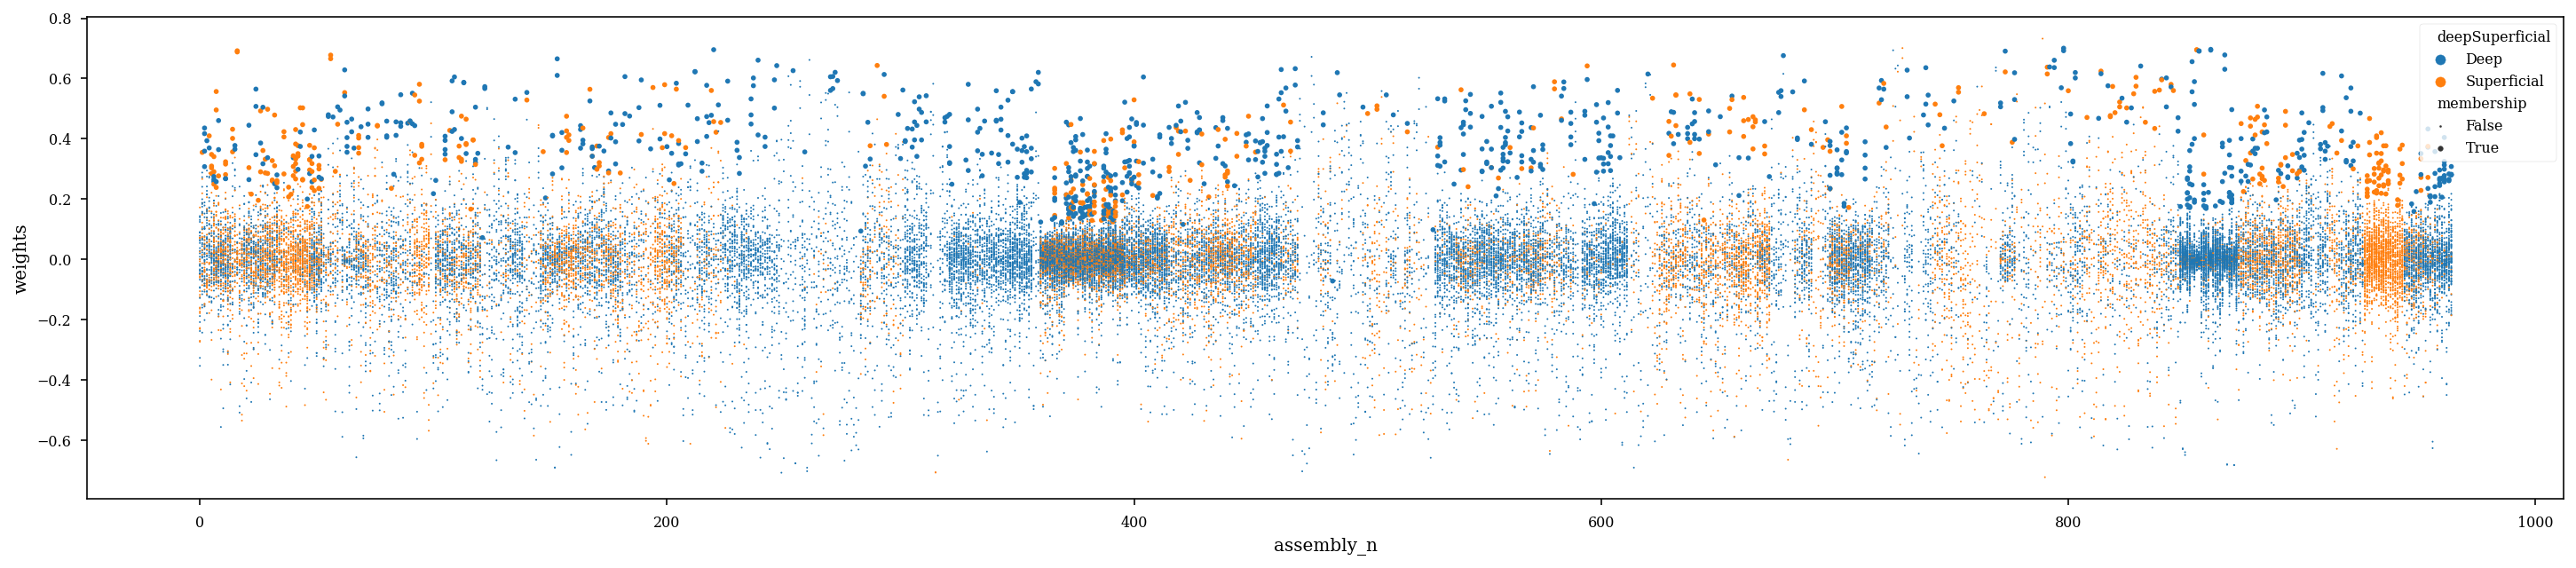

In [63]:
# plt.plot(df.assembly_n,df.weights)
plt.figure(figsize=(25,5))
sns.scatterplot(x="assembly_n", y="weights",
                hue="deepSuperficial", size="membership",
                sizes=(8, 1), linewidth=0,
                data=df)

# plt.xlim(0,100)                

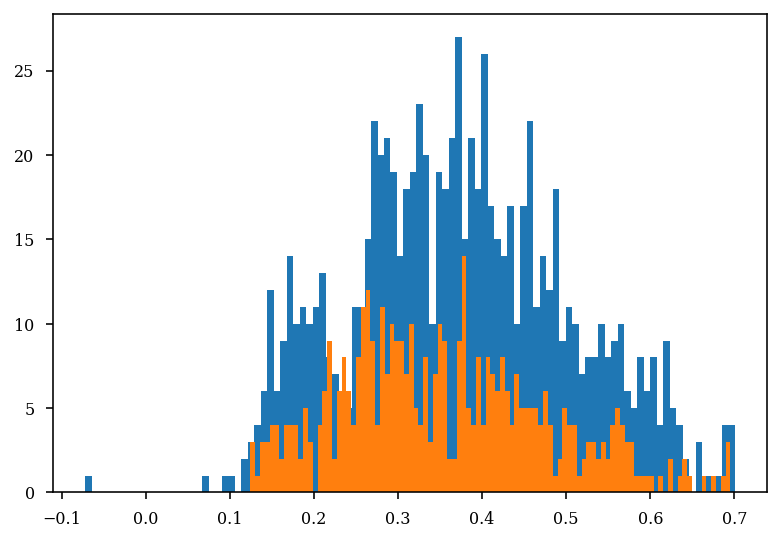

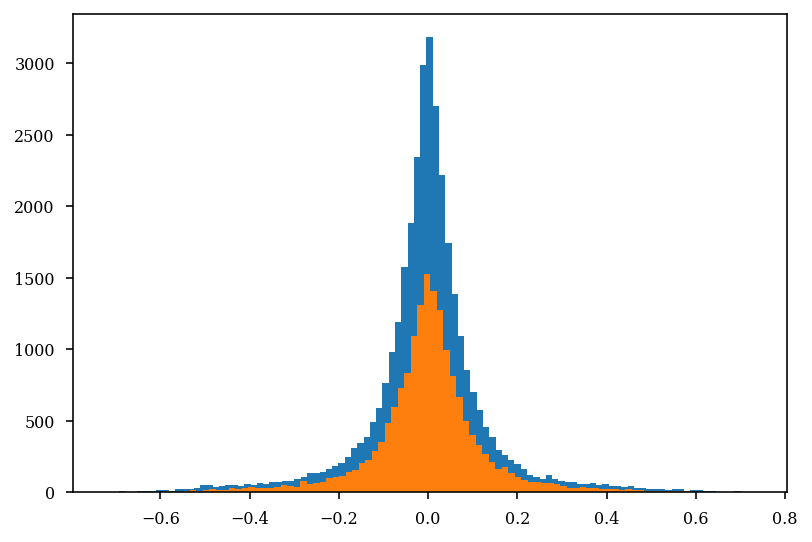

In [8]:

# sns.histplot(
#     df,
#     x="weights", hue="membership",
#     multiple="stack",
#     palette="light:m_r",
#     edgecolor=".3",
#     linewidth=.5
# )

plt.hist(df.weights[(df.membership == True) & (df.deepSuperficial == "Deep")],100)
plt.hist(df.weights[(df.membership == True) & (df.deepSuperficial == "Superficial")],100)
plt.show()

plt.hist(df.weights[(df.deepSuperficial == "Deep")],100)
plt.hist(df.weights[(df.deepSuperficial == "Superficial")],100)
plt.show()

In [35]:
def pvalue(shuff_dist,score):
        # DOI: 10.2202/1544-6115.1585
        return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

def mixing_index(values):
    if isinstance(values, float):
        if values > 0.5:
            return (values * -1) + 1
    else:
        values[values > .5] = (values[values > .5] * -1) + 1
    return values

obs = []
shuff_out = []

for session in sessions:

    with open(session, 'rb') as f:
        results = pickle.load(f)

    assmbl = results['patterns_inside_ripples']
    if len(assmbl) == 0:
        continue
    thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2
    for idx in np.array((assmbl.T)>thres).T:
        if (idx.sum() == 0) | (idx.sum() == 1):
            continue
        
        labels = results['deepSuperficial'].values.copy()
        # print(labels[idx],sum(labels[idx] == "Deep") / idx.sum())
        obs.append(sum(labels[idx] == "Deep") / idx.sum())
        # obs = mixing_index(obs)

        for i_shuff in range(1000):
            labels = results['deepSuperficial'].values.copy()
            random.shuffle(labels)
            shuff_out.append(sum(labels[idx] == "Deep") / idx.sum())
        # shuff_out = mixing_index(np.array(shuff_out))   

        # plt.figure()
        # plt.hist(shuff_out)  
        # plt.title(pvalue(shuff_out,obs))
        # plt.axvline(obs,color='r')  


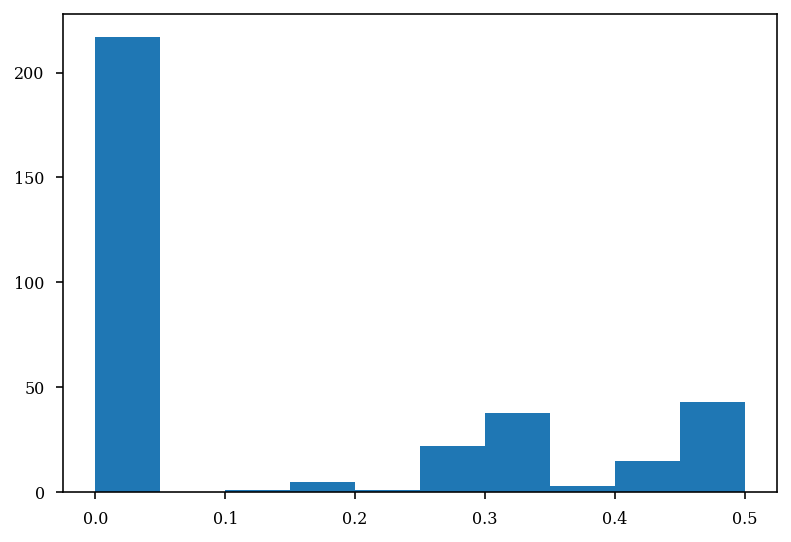

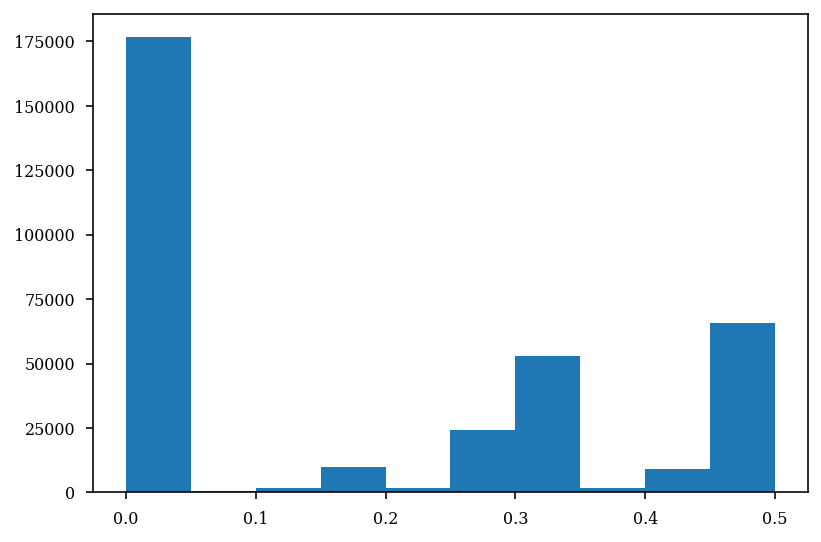

In [44]:
plt.hist(mixing_index(np.array(obs)))
plt.show()
plt.hist(mixing_index(np.array(shuff_out)))
plt.show()

In [33]:
import random

# assmbl = results['patterns_inside_ripples']
# thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2

# for idx in np.array((assmbl.T)>thres).T:
#     sum(results['deepSuperficial'][idx].values == "Deep") / idx.sum()

shuff_out = []
obs = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    assmbl = results['patterns_inside_ripples']
    if len(assmbl) == 0:
        continue
    thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2

    # labels = results['deepSuperficial'].values.copy()

    obs.append(sum(labels[idx] == "Deep") / idx.sum())

    for i_shuff in range(1000):
        for idx in np.array((assmbl.T)>thres).T:
            if (idx.sum() == 0) | (idx.sum() == 1):
                continue
            labels = results['deepSuperficial'].values.copy()
            random.shuffle(labels)

            shuff_out.append(sum(labels[idx] == "Deep") / idx.sum())
shuff_out = np.hstack(shuff_out)


In [99]:
shuff_out[shuff_out > .5] = (shuff_out[shuff_out > .5] *-1) + 1

In [22]:
assmbl = results['patterns_inside_ripples']

thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2
# plt.imshow((assmbl.T))
# plt.show()
# plt.imshow((assmbl.T)>thres)
for idx in np.array((assmbl.T)>thres).T:
    print(results['deepSuperficial'][idx].values)

[]
['Superficial']
['Deep' 'Deep' 'Deep' 'Deep']
['Deep']
['Superficial' 'Deep']
['Superficial' 'Superficial' 'Superficial' 'Superficial']


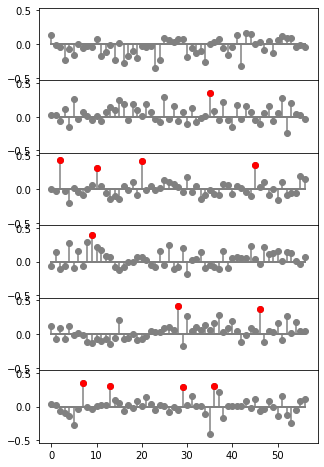

In [124]:
# results['patterns_outside_ripples'].shape
# results['patterns_inside_ripples'].shape
# sns.heatmap(results['patterns_outside_ripples'])
# plt.show()
# sns.heatmap(results['patterns_inside_ripples'])
group_colors = {"deep": '#7b3294',
            "deep_non_member": '#c2a5cf',
            'sup': '#008837',
            'sup_non_member': '#a6dba0'} 

def plot_lolipop(patterns,colors):
    fig, axs = plt.subplots(patterns.shape[0],1, figsize=(5, 8), edgecolor='k')
    fig.subplots_adjust(hspace = 0.00, wspace=0)
    axs = axs.ravel()

    for i,assmbl in enumerate(patterns):
        markerline, stemlines, baseline = axs[i].stem(np.arange(len(assmbl)),assmbl,linefmt='grey')
        markerline.set_markerfacecolor('grey')
        markerline.set_markeredgecolor('grey')
        plt.setp(baseline, color='grey', linewidth=2,zorder=-100)
        thres = np.mean(assmbl) + np.std(assmbl)*2
        idx = assmbl > thres
        axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)



    for i in range(patterns.shape[0]):
        axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
        # axs[i].axis('off')

plot_lolipop(results['patterns_inside_ripples'],colors)        
# plot_lolipop(results['patterns_outside_ripples']) 
# plt.gca().invert_yaxis()

In [120]:



# get smooth vector-function containing each neuron's z-scored instantaneous FR
z_t, ts = get_z_t(st)

In [121]:
patterns, significance, zactmat = assembly.runPatterns(binned_st.data)
assemblyAct = assembly.computeAssemblyActivity(patterns, z_t)

In [122]:
assembly_act = nel.AnalogSignalArray(data=assemblyAct,timestamps=ts,fs=1000)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AxesSubplot:>

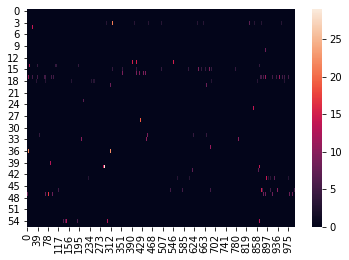

In [123]:
sns.heatmap(zactmat[:,0:1000])

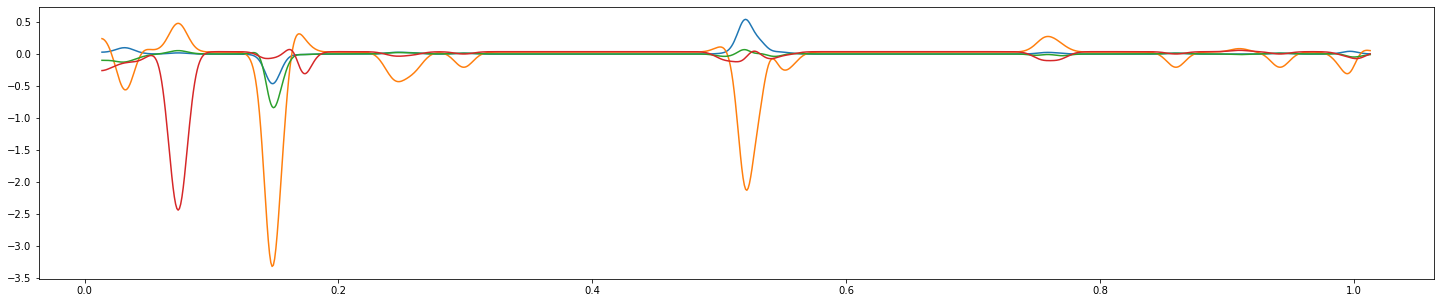

In [124]:
plt.figure(figsize=(25,5))
plt.plot(ts[0:1000],assemblyAct[0,0:1000])
plt.plot(ts[0:1000],assemblyAct[1,0:1000])
plt.plot(ts[0:1000],assemblyAct[2,0:1000])
plt.plot(ts[0:1000],assemblyAct[3,0:1000])
plt.show()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


AttributeError: 'Line2D' object has no property 'cmap'

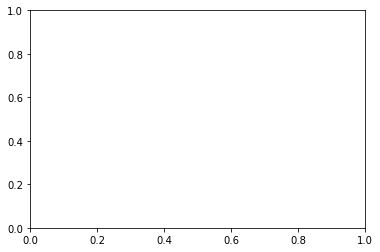

In [58]:
rip_n = 4
cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

plt.plot(assembly_act[ripple_epochs[rip_n]].abscissa_vals ,assembly_act[ripple_epochs[rip_n]].data.T,cmap=cmap)
plt.show()
# plt.eventplot(st[ripple_epochs[4]].data)
# plt.show()

import matplotlib


thres = patterns.mean(axis=1) + patterns.std(axis=1)
temp_pattens = patterns.copy()
temp_pattens[patterns <  thres[:,np.newaxis]] = 0
assmbl_unit_id = temp_pattens.argmax(axis=0)

axs = plt.gca()
color_idx = 0
for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
    npl.rasterplot(st[ripple_epochs[rip_n]][:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=2, lh=1, ax=axs, vertstack=True)
    axs.plot(assembly_act[ripple_epochs[rip_n]].abscissa_vals,assembly_act[ripple_epochs[rip_n]].data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=.75,zorder=1000-i,alpha=1)
    color_idx+=1

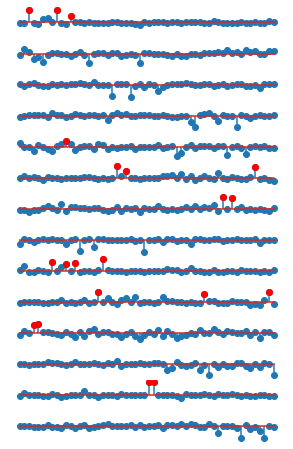

In [125]:
fig, axs = plt.subplots(patterns.shape[0],1, figsize=(5, 8), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):
    axs[i].stem(np.arange(len(assmbl)),assmbl)
    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
    
for i in range(patterns.shape[0]):
    axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].axis('off')

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


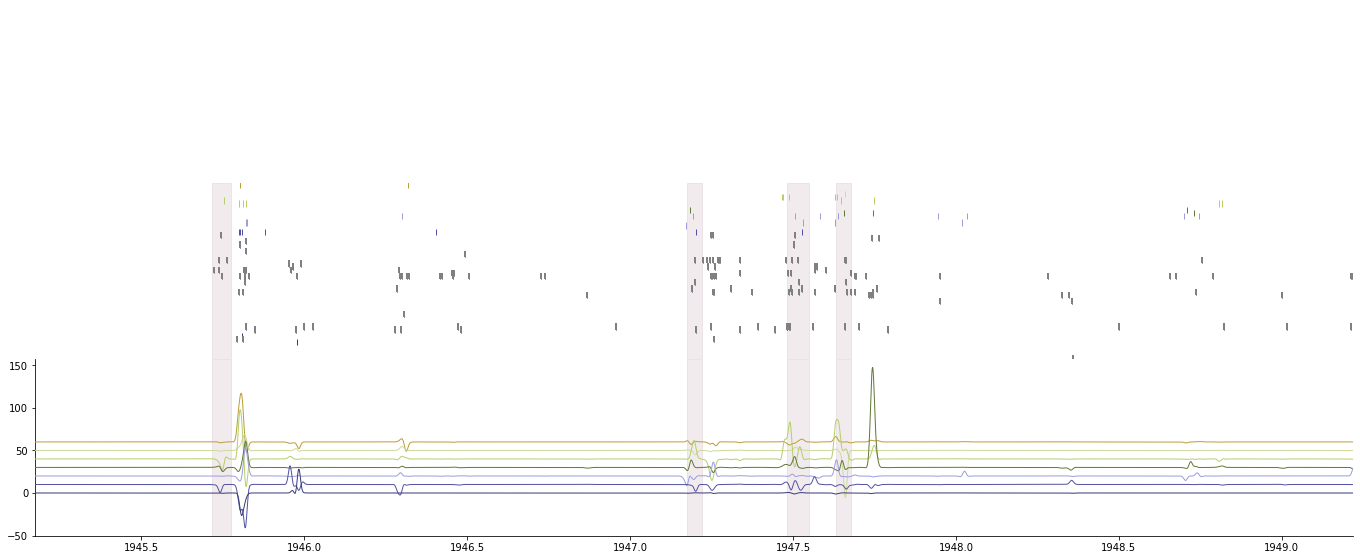

In [136]:
def plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=True,vertstack=True):
    
    cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

    interval = nel.EpochArray(interval)
    st = st[interval]

    assembly_act = assembly_act[interval]
    
    thres = patterns.mean(axis=1) + patterns.std(axis=1)*2
    temp_pattens = patterns.copy()
    temp_pattens[patterns <  thres[:,np.newaxis]] = 0
    assmbl_unit_id = temp_pattens.argmax(axis=0)
    
    color_idx = 0
    for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
        npl.rasterplot(st[:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=1, lh=2, ax=axs[1], vertstack=vertstack)
        axs[2].plot(assembly_act.abscissa_vals,assembly_act.data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=1,zorder=1000-i,alpha=1,label='assembly:'+str(unit_id))
        color_idx+=1
        
    npl.rasterplot(st[:,np.where(temp_pattens.max(axis=0) == 0)[0]+1],color='grey', lw=2, lh=2, ax=axs[1], vertstack=True)

    axs[1].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[2].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[1].axis('off')
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["top"].set_visible(False)

fig, axs = plt.subplots(3,1, figsize=functions.set_size('thesis', fraction=4, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()  

rip_n = 201
interval = [ripple_epochs[rip_n].start-2, ripple_epochs[rip_n].stop+2]

plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=False,vertstack=True)

axs[0].axis('off')

for item in ripples[ripples['peaks'].between(interval[0], interval[1])].itertuples():
    axs[1].axvspan(item.start, item.stop, alpha=0.1, color='#843b62', zorder=-2000)
    axs[2].axvspan(item.start, item.stop, alpha=0.1, color='#843b62', zorder=-2000)

# axs[2].legend()

In [ ]:
assembl_strength = []
assembl_frac = []

for ripple in ripples.itertuples():
    # pull out current assembly based on ripple width
    curr_assembl = assemblyAct[:,(ts >= ripple.start_time) & (ts <= ripple.end_time)]
    # Assembly strength during SPW-R periods
    assembl_strength.append(np.median(curr_assembl.max(axis=0)[curr_assembl.max(axis=0) > 5]))
    
    # fraction of active assemblies active during SPW-R 
    assembl_frac.append(sum(np.any(curr_assembl > 5,axis=1)) / curr_assembl.shape[0])

n_assembl = (patterns.shape[0])
n_units = (patterns.shape[1])
n_assembl_n_cell_frac = (patterns.shape[0]/patterns.shape[1])    

# number of cells that contribute significantly (>2 SD) to each assembly     
n_cells_per_assembl_ = np.sum(patterns > (patterns.mean(axis=1) + patterns.std(axis=1)*2)[:, np.newaxis],axis=1)
n_cells_per_assembl = (n_cells_per_assembl_[n_cells_per_assembl_ > 0].mean())  